In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('processed_airbnb_data_ML.csv')

Price Skewness (before log): 2.890299930157411
Price Skewness (after log): 0.5043948902368507


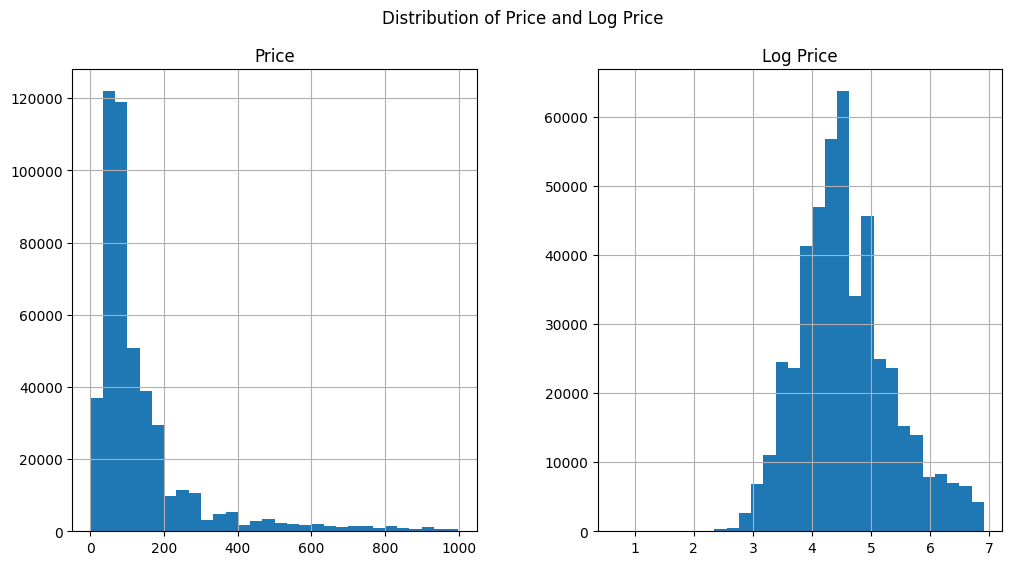

In [3]:
# Check skewness of prices
print("Price Skewness (before log):", data['Price'].skew())

# Apply log transformation to the 'Price' column
data['Log Price'] = np.log1p(data['Price'])  # Use log1p to handle zero prices safely

# Check skewness after log transformation
print("Price Skewness (after log):", data['Log Price'].skew())

# Histogram to compare distributions
data[['Price', 'Log Price']].hist(bins=30, figsize=(12, 6), layout=(1, 2))
plt.suptitle("Distribution of Price and Log Price")
plt.show()

In [4]:
# Normalize 'Review Scores Rating' to the range 0-10
data['Review Scores Rating'] = data['Review Scores Rating'] / 10

# Verify the transformation
print("Updated 'Review Scores Rating' (normalized to 0-10):")
print(data['Review Scores Rating'].describe())

Updated 'Review Scores Rating' (normalized to 0-10):
count    469754.000000
mean          6.936252
std           4.108872
min           0.000000
25%           0.000000
50%           9.200000
75%           9.800000
max          10.000000
Name: Review Scores Rating, dtype: float64


In [5]:
# List of review-related columns
review_columns = [
    'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness',
    'Review Scores Checkin', 'Review Scores Communication',
    'Review Scores Location', 'Review Scores Value'
]

# Calculate the average review score for each listing
data['Average Review'] = data[review_columns].mean(axis=1)

# Verify the new column
print("Average Review (0-10) column created successfully:")
print(data[['Average Review']].describe())

Average Review (0-10) column created successfully:
       Average Review
count   469754.000000
mean         7.059951
std          4.164638
min          0.000000
25%          0.000000
50%          9.428571
75%          9.828571
max         10.000000


In [7]:
# Select features and target, excluding 'Country', 'City', and 'Neighbourhood Cleansed'
features = [
    'Property Type', 'Room Type', 'Country', 'Average Review', 'City',
    'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
    'Guests Included', 'Is there Security Deposit',
    'Is there Cleaning Fee', 'Has Notes', 'Has Amenities',
    'Is Capital', 'Is Short Term', 'Charges for Extra People',
    'House Rules Length', 'House Rules Category', 'Response Rate Category',
    'Has Info about Host',
    'Description Length',
]
target = 'Log Price'

# Preprocess data
categorical_features = data.select_dtypes(include=['object']).columns.intersection(features)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.intersection(features)

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predict on training and test sets (without reversing the log transformation)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metrics for log-transformed target
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics for log-transformed target
print("Training Metrics (Log Target):")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}\n")

print("Test Metrics (Log Target):")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}\n")

# Extract and print coefficients
if hasattr(pipeline['regressor'], 'coef_'):
    # Get feature names
    feature_names = numeric_features.tolist() + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )

    coefficients = pipeline.named_steps['regressor'].coef_
    print("Feature Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")

# Summary
print("\nModel Summary:")
print(f"Total Features: {len(feature_names)}")
print(f"Top 5 Positive Influences: {sorted(zip(coefficients, feature_names), reverse=True)[:5]}")
print(f"Top 5 Negative Influences: {sorted(zip(coefficients, feature_names))[:5]}")

Training Metrics (Log Target):
Mean Squared Error: 0.17
R^2 Score: 0.73

Test Metrics (Log Target):
Mean Squared Error: 0.17
R^2 Score: 0.72

Feature Coefficients:
Accommodates: 0.1860
Bathrooms: 0.0569
Bedrooms: 0.1172
Beds: -0.0438
Guests Included: 0.0318
Is there Security Deposit: 0.0114
Is there Cleaning Fee: 0.0028
Has Notes: -0.0012
Has Amenities: -0.0127
Is Capital: 0.0279
Is Short Term: -0.0086
Charges for Extra People: -0.0651
House Rules Length: 0.0028
Has Info about Host: 0.0121
Description Length: 0.0128
Average Review: -0.0470
City_abbotsford: 0.0579
City_acilia-castel fusano-ostia antica: -0.0952
City_agoura hills: 0.1476
City_alaró: -0.0046
City_alba-penia: -0.1404
City_albert park: 0.3289
City_alcudia: -0.2034
City_alcúdia: -0.1869
City_alexandria: 0.1107
City_algaida: 0.0572
City_alhambra: -0.2424
City_allambie heights: 0.1396
City_allston: 0.1115
City_alphington: -0.0937
City_altadena: 0.0566
City_altona: -0.0457
City_altona north: -0.2985
City_amsterdam: 0.1312
City_

In [8]:
# Select features and target, excluding 'Country', 'City', and 'Neighbourhood Cleansed'
features = [
    'Property Type', 'Room Type', 'Country', 'City',
    'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
    'Guests Included', 'Is there Security Deposit',
    'Is there Cleaning Fee', 'Has Notes', 'Has Amenities',
   'Charges for Extra People',
   'House Rules Category',
    'Has Info about Host',
]
target = 'Log Price'

# Preprocess data
categorical_features = data.select_dtypes(include=['object']).columns.intersection(features)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.intersection(features)

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predict on training and test sets (without reversing the log transformation)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metrics for log-transformed target
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics for log-transformed target
print("Training Metrics (Log Target):")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}\n")

print("Test Metrics (Log Target):")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}\n")

# Extract and print coefficients
if hasattr(pipeline['regressor'], 'coef_'):
    # Get feature names
    feature_names = numeric_features.tolist() + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )

    coefficients = pipeline.named_steps['regressor'].coef_
    print("Feature Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")

# Summary
print("\nModel Summary:")
print(f"Total Features: {len(feature_names)}")
print(f"Top 5 Positive Influences: {sorted(zip(coefficients, feature_names), reverse=True)[:5]}")
print(f"Top 5 Negative Influences: {sorted(zip(coefficients, feature_names))[:5]}")

Training Metrics (Log Target):
Mean Squared Error: 0.17
R^2 Score: 0.72

Test Metrics (Log Target):
Mean Squared Error: 0.18
R^2 Score: 0.72

Feature Coefficients:
Accommodates: 0.1875
Bathrooms: 0.0581
Bedrooms: 0.1194
Beds: -0.0440
Guests Included: 0.0304
Is there Security Deposit: 0.0117
Is there Cleaning Fee: -0.0011
Has Notes: -0.0013
Has Amenities: -0.0146
Charges for Extra People: -0.0688
Has Info about Host: 0.0092
City_abbotsford: 0.0600
City_acilia-castel fusano-ostia antica: -0.0793
City_agoura hills: 0.1258
City_alaró: 0.0007
City_alba-penia: -0.1222
City_albert park: 0.3290
City_alcudia: -0.1699
City_alcúdia: -0.1833
City_alexandria: 0.1139
City_algaida: 0.0590
City_alhambra: -0.2528
City_allambie heights: 0.1625
City_allston: 0.1071
City_alphington: -0.1016
City_altadena: 0.0543
City_altona: -0.0649
City_altona north: -0.2988
City_amsterdam: 0.1722
City_amsterdam zuid-oost: -0.1092
City_amsterdam-zuidoost: -0.0940
City_andalo: -0.4141
City_anderlecht: -0.0378
City_andratx

In [9]:
# Select features and target, excluding 'Country', 'City', and 'Neighbourhood Cleansed'
features = [
    'Property Type', 'Room Type', 'Country', 'City',
    'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
    'Guests Included']
target = 'Log Price'

# Preprocess data
categorical_features = data.select_dtypes(include=['object']).columns.intersection(features)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.intersection(features)

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predict on training and test sets (without reversing the log transformation)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metrics for log-transformed target
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics for log-transformed target
print("Training Metrics (Log Target):")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}\n")

print("Test Metrics (Log Target):")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}\n")

# Extract and print coefficients
if hasattr(pipeline['regressor'], 'coef_'):
    # Get feature names
    feature_names = numeric_features.tolist() + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )

    coefficients = pipeline.named_steps['regressor'].coef_
    print("Feature Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")

# Summary
print("\nModel Summary:")
print(f"Total Features: {len(feature_names)}")
print(f"Top 5 Positive Influences: {sorted(zip(coefficients, feature_names), reverse=True)[:5]}")
print(f"Top 5 Negative Influences: {sorted(zip(coefficients, feature_names))[:5]}")

Training Metrics (Log Target):
Mean Squared Error: 0.18
R^2 Score: 0.72

Test Metrics (Log Target):
Mean Squared Error: 0.18
R^2 Score: 0.71

Feature Coefficients:
Accommodates: 0.1754
Bathrooms: 0.0630
Bedrooms: 0.1312
Beds: -0.0438
Guests Included: 0.0018
City_abbotsford: 0.0984
City_acilia-castel fusano-ostia antica: -0.1211
City_agoura hills: 0.0623
City_alaró: -0.0190
City_alba-penia: -0.1125
City_albert park: 0.3546
City_alcudia: -0.1538
City_alcúdia: -0.1810
City_alexandria: 0.1432
City_algaida: 0.0389
City_alhambra: -0.3172
City_allambie heights: 0.1822
City_allston: 0.0428
City_alphington: -0.0921
City_altadena: -0.0018
City_altona: -0.0264
City_altona north: -0.3126
City_amsterdam: 0.1843
City_amsterdam zuid-oost: -0.1225
City_amsterdam-zuidoost: -0.0986
City_andalo: -0.4173
City_anderlecht: -0.0398
City_andratx: 0.3162
City_annandale: 0.1680
City_antwerp: 0.1844
City_antwerpen: 0.1229
City_aptos: 0.2251
City_arcadia: -0.1774
City_arco: -0.2464
City_arenal: -0.8611
City_arian

In [10]:
from joblib import dump

# Save the trained model
dump(pipeline, 'linear_regression_model.joblib')

['linear_regression_model.joblib']

In [11]:
# Count unique values in the 'Country' column
country_counts = data['Country'].value_counts()

# Print the unique values and their counts
print("Unique countries and their counts:")
for country, count in country_counts.items():
    print(f"{country}: {count}")


Unique countries and their counts:
United States: 128913
United Kingdom: 58694
France: 55707
Spain: 43826
Australia: 37047
Italy: 31544
Canada: 30128
Germany: 20191
Denmark: 16174
Netherlands: 14967
Austria: 7722
Belgium: 7190
Ireland: 6141
Greece: 4893
Hong Kong: 4445
Switzerland: 2172


In [12]:
# Count unique values in the 'Country' column
city_counts = data['City'].value_counts()

# Print the unique values and their counts
print("Unique city and their counts:")
for city, count in city_counts.items():
    print(f"{city}: {count}")

Unique city and their counts:
paris: 53942
london: 46779
berlin: 20191
new york: 19043
los angeles: 18808
roma: 18401
barcelona: 17111
brooklyn: 16099
amsterdam: 14721
madrid: 12832
toronto: 12464
københavn: 11203
austin: 8998
san francisco: 8228
montréal: 7561
washington: 7270
wien: 6073
edinburgh: 6009
san diego: 5965
rome: 5934
vancouver: 5437
new orleans: 5141
chicago: 5118
dublin: 4197
venezia: 4011
seattle: 3750
athina: 3532
portland: 3423
boston: 3314
nashville: 3143
hong kong: 3078
queens: 2621
montreal: 2566
copenhagen: 2517
denver: 2397
melbourne: 2076
palma: 1952
frederiksberg: 1926
venice: 1897
vienna: 1629
oakland: 1563
bondi beach: 1449
genève: 1407
bruxelles: 1222
ville de québec: 1174
long beach: 1062
athens: 1025
ixelles: 996
antwerpen: 992
pollença: 979
santa monica: 962
west hollywood: 919
manly: 875
greater london: 834
alcúdia: 833
manchester: 801
surry hills: 794
bondi: 717
palma de mallorca: 714
richmond: 680
saint-gilles: 650
coogee: 636
southbank: 625
bronx: 610

In [14]:
# Extract unique cities for each country
unique_cities_by_country = data.groupby('Country')['City'].unique()

# Display as a dictionary-like structure
for country, cities in unique_cities_by_country.items():
    print(f"{country}: {list(cities)}")

Australia: ['melbourne', 'docklands', 'south melbourne', 'kensington', 'southbank', 'east melbourne', 'north melbourne', 'west melbourne', 'carlton', 'south yarra', 'middle park', 'elwood', 'saint kilda', 'albert park', 'st kilda', 'saint kilda east', 'port melbourne', 'brunswick', 'brunswick west', 'brunswick east', 'coburg', 'pascoe vale', 'hadfield', 'blackburn', 'mont albert', 'box hill', 'burwood', 'croydon', 'mitcham', 'doncaster', 'warrandyte', 'windsor', 'armadale', 'toorak', 'malvern east', 'prahran', 'heidelberg', 'ivanhoe', 'northcote', 'fairfield', 'preston', 'reservoir', 'thornbury', 'saint albans', 'sunshine', 'frankston', 'seaford', 'west footscray', 'yarraville', 'maidstone', 'seddon', 'clayton', 'glen waverley', 'wheelers hill', 'eltham', 'greensborough', 'newport', 'williamstown', 'altona', 'bonbeach', 'parkdale', 'clayton south', 'footscray', 'springvale', 'keysborough', 'wyndham vale', 'point cook', 'westmeadows', 'sunbury', 'tullamarine', 'altona north', 'epping', 

In [17]:
# Count unique values in the 'Country' column
property_counts = data['Property Type'].value_counts()

# Print the unique values and their counts
print("Unique city and their counts:")
for city, count in property_counts.items():
    print(f"{city}: {count}")

Unique city and their counts:
Apartment: 339081
House: 87546
Bed & Breakfast: 11208
Condominium: 10019
Loft: 5768
Townhouse: 5659
Villa: 2703
Guesthouse: 1574
Bungalow: 1163
Dorm: 1061
Boat: 864
Cabin: 651
Chalet: 567
Boutique hotel: 490
Serviced apartment: 411
Hostel: 374
Camper/RV: 303
Timeshare: 174
Guest suite: 138


In [18]:
# Count unique values in the 'Country' column
Room_counts = data['Room Type'].value_counts()

# Print the unique values and their counts
print("Unique city and their counts:")
for city, count in Room_counts.items():
    print(f"{city}: {count}")

Unique city and their counts:
Entire home/apt: 297699
Private room: 163737
Shared room: 8318


In [ ]:
# Count unique values in the 'Country' column
 = data['Room Type'].value_counts()

# Print the unique values and their counts
print("Unique city and their counts:")
for city, count in Room_counts.items():
    print(f"{city}: {count}")

In [19]:
# Count unique values in the 'Country' column
Room_counts = data['Bed Type'].value_counts()

# Print the unique values and their counts
print("Unique city and their counts:")
for city, count in Room_counts.items():
    print(f"{city}: {count}")

Unique city and their counts:
Real Bed: 453741
Pull-out Sofa: 9423
Futon: 3451
Couch: 1925
Airbed: 1214


In [21]:
# Count unique values in the 'Country' column
Room_counts = data['Guests Included'].value_counts()

# Print the unique values and their counts
print("Unique city and their counts:")
for city, count in Room_counts.items():
    print(f"{city}: {count}")

Unique city and their counts:
1: 331660
2: 88429
4: 24180
3: 10320
6: 6069
5: 3725
8: 1767
0: 1650
7: 671
10: 594
12: 224
9: 173
16: 96
14: 68
15: 48
11: 48
13: 31
20: 1
